
# Adaptive Color Transfer With Relaxed Optimal Transport - Notebook
### Antoine DUSSOLLE & Paul NANTAS

## Introduction

As part of the computational imaging course, we implemented the algorithm of the paper *Adaptive Color Transfer With Relaxed Optimal Transport*. The aim of this algorithm is to perform color transfer between images using optimal transport techniques. 
Given two input images, color transfer algorithms impose the color palette of the second image onto the geometry of the first one. 

***Basically, the problem is to find a new image w whose geometry is as close as possible to the source image u and whose color distribution is close to the one of the exemplar image v.***

We can divide this algorithm in three main parts:  
1. **SuperPixel segmentation** : The first step is to segment an image into superpixels. We operate the superpixel segmentation with a given number of clusters on the input and the color-palette images. It allows to keep a more local information about color in images.  

2. **Optimal transport** : Once the image is segmented into superpixels, the next step is to find the best matching between the clusters X of image u and the clusters Y of image v. Here comes the optimal transport techniques and more particularly the relaxed weighted optimal transport mentionned in the article.

3. **Image synthesis and post processing**: This part of the process is made for recovering the sharp details of the input image lost in the process.
 

Please find below an example of successful color transfer:

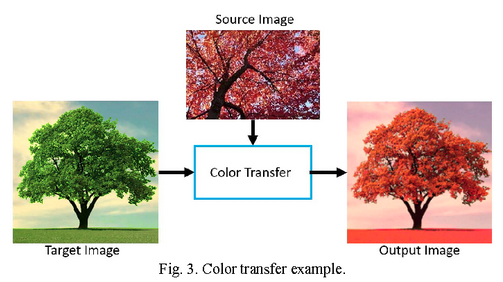

In [ ]:
from IPython.display import Image
Image(filename='color_trasnfer_example.png') 

In this notebook, we tried to show different methods of color transfer and tried to evaluate performances which is not easy to do for those kind of image processing tasks given the subjectivity of what a good color transfer would be.  

In view of the complexity of this algorithm and after many attemps of coding, we have decided to use some parts of code from Rachel Blin's github repository to help us find a way to solve the constrained version of our optimization problem. However, even using her code as a basis for our work we did not suceed in solving the constrained optimization problem even though we tried using several different libraries.  
  
 The link to this repository is the following one : 
[Colorization Optimal Transport repository](https://github.com/RachelBlin/Colorization-optimal-transport)  

## Data
For all this notebook, we have 2 reference images for the input image and the color-palette image.

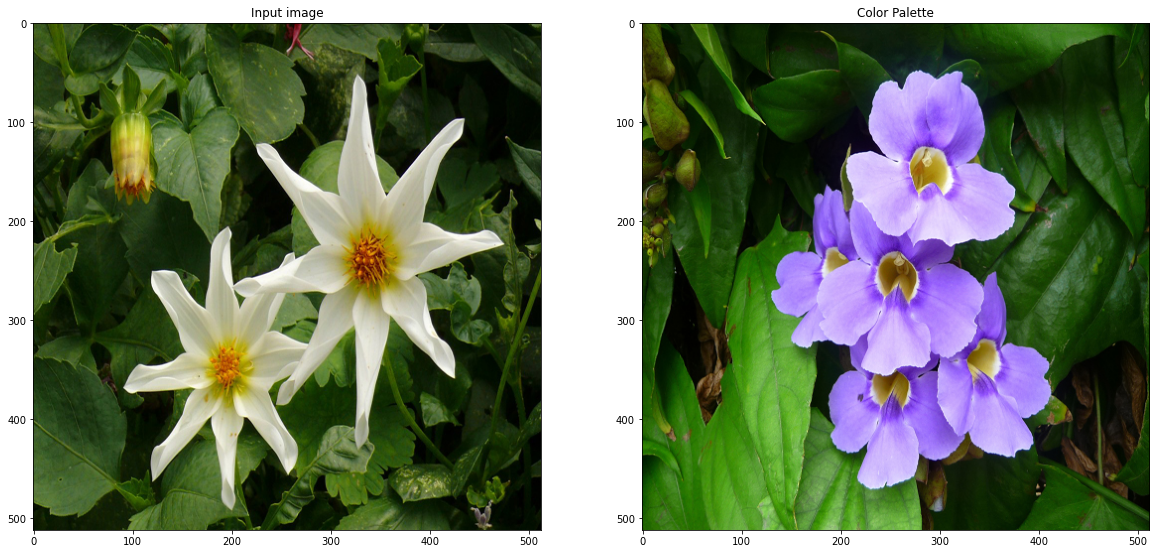

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
u = plt.imread("Data/flower_1.jpg")
v = plt.imread("Data/flower_2.jpg")
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title("Input image")
plt.imshow(u)
plt.subplot(1, 2, 2)
plt.title("Color Palette")
plt.imshow(v)
plt.show()

## Algoritm 
**Important** : Given that the github repository is using a singular library named *Gurobipy* for the optimization problem, we performed the algorithm before and saved ouput images from it, since a license per computer was required in order to use the library. (we did not suceed implementing the optimization using only standard libraries)      **!!!! Important !!!!**  

Some function will be defined in the notebook to have more context.

### SuperPixel segmentation
In this section, we performed the SuperPixel segmentation on both input and color-palette images. To do so, the slic algorithm from scikit-image was used with 120 clusters.

In [ ]:
from skimage.segmentation import slic  # super pixels
from skimage import color

def superpixel_segmentation(image, num_segments):
    """ 
    Segment an image into an approximative number of superpixels.
    inputs:
        -image: a numpy array to be segmented
        -num_segments: the number of of desired segments in the segmentation

    returns:
        - the number of segments after superpixel segmentation
        - the content of each cluster (center coordinates, mean of color)"""
    
    segments = slic(image, n_segments=num_segments, sigma=5) # segmentation using the k-means clustering
    clusters = np.zeros((len(np.unique(segments)), 5))
    superpixels = color.label2rgb(segments, image, kind='avg')

    for c in np.unique(segments):
        indexes = np.where(segments==c)
        mean_color = superpixels[indexes[0][0], indexes[1][0]] # just access the first element of superpixel since all elements of superpixel are average color of cluster
        mean_indexes = np.array([int(np.round(np.mean(indexes[0]))), int(np.round(np.mean(indexes[1])))])
        clusters[c] = np.concatenate((mean_indexes, mean_color), axis=None)

    return segments, clusters, superpixels

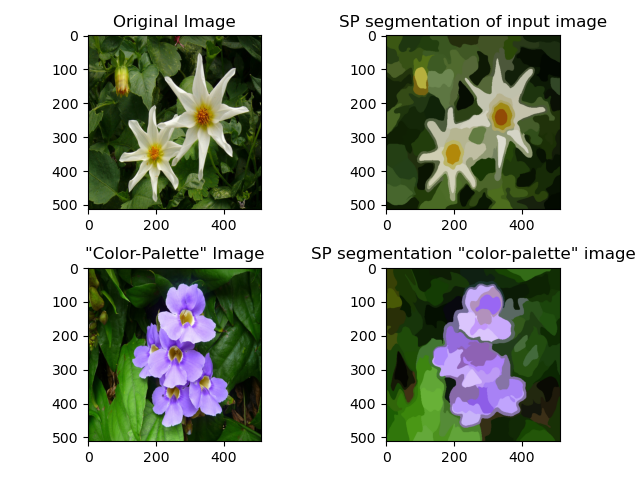

In [ ]:
from IPython.display import Image
Image(filename='Results/superpixel.png') 


We can see that during the superpixel segmentation process we lost the information about the center of the flowers being yellow for the *color-palette* image. This is probably due to too large superpixels, a way to avoid this issue might have been to increase the number of clusters inputed as argument to the SLIC algorithm.

### Color Palette Transfer function & application to clusters transport

The aim of clusters transport is to match colors of the clusters from the color-palette image to the input one. 

The key element of our approach is the change of the image representation space in which we compute the transportation cost and the transportation map.

Unlike more basic approaches where we would directly apply the rgb histogram of the image, which serves as a "color palette", to the original image or where we would transport the colors pixel by pixel from image 2 to image 1, here we place ourselves in the space of super pixels by doing so we reason more at the pixel region scale rather than at a pixel-wise scale, allowing us to keep better track of the geometry information of the image for the color transfer.

In order to define our "color palette transfer" function, which will allow us to compute the final color-transfered image afterwards (we also used this function at an intermediate step to compute the superpixel transfered image aswell), we first need to define :
- a weighted graph of our superpixel centroids
- a transport cost matrix from image 1 to image 2
- solve the optimization problem in order to find the optimal transport matrix of image 1 towards image 2

(and incidentally the superpixel clusters of image 2, which we computed above)

####Unconstrained optimal transport####

First we tried to implement a simpler version of the optimal transport problem which does not account for the regularization nor the fidelity terms. 

Please find below a formulation of the optimization problem we implemented in order to determine the optimal transport matrix P* of features X of image 1 towards features Y of image 2 :

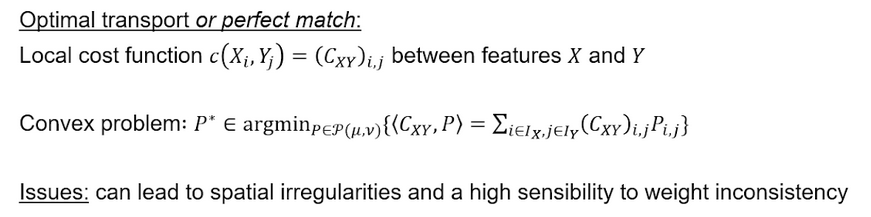

In [ ]:
from IPython.display import Image
Image(filename='unconstrainted_optimal_transport.png') 

We start by assigning a weight to every clusters for both images, we will then use to compute this optimal transport matrix P*.

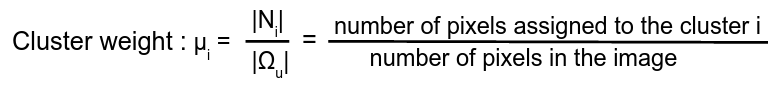

In [ ]:
from IPython.display import Image
Image(filename='cluster_weight.png') 

In [ ]:
def cluster_weights(segments):
    """
    Compute the weights of each cluster.
    inputs:
        - segments: a 2D array which is an integer mask indicating segment labels
    returns: 
        - a list of the weights associated to each cluster given the following formula N_pixel_cluster/N_pixel_image
    """

    size_image = segments.shape[0]*segments.shape[1]
    weights = np.zeros((len(np.unique(segments)),))

    for c in np.unique(segments):
        indexes = np.where(segments==c)
        n_pixels = len(indexes[0])
        weights[c] = n_pixels/size_image
    
    return weights
     

We then define a transport cost function which will allow us to compute the transport cost matrix $C(X,Y)$, and once we have done that we can finally compute the optimal transport matrix P* solving the optimization problem mentioned above (using projection_matrix()). 

In [ ]:
import ot
def transport_cost(X, Y):
    """
    Compute the matrix CXY in which CXY(i,j) is the cost to transport X(i) towards Y(j)
    inputs:
        - X: the first set of features of size Nx of which we want to keep the spatial features
        - Y: the second set of features of size Ny of which we want to keep the color features
    
    returns:
        - the transport cost of X towards Y, a matrix of shape Nx*Ny
    """

    Nx = len(X)
    Ny = len(Y)
    CXY = np.zeros((Nx, Ny))

    X_norm = X.copy()

    X_norm[:, 0] = X[:, 0] / 500
    X_norm[:, 1] = X[:, 1] / 500
    X_norm[:, 2:] = X[:, 2:] / 255

    Y_norm = Y.copy()

    Y_norm[:, 0] = Y[:, 0] / 500
    Y_norm[:, 1] = Y[:, 1] / 500
    Y_norm[:, 2:] = Y[:, 2:] / 255

    for idx, _ in np.ndenumerate(CXY):
        CXY[idx] = np.linalg.norm((X_norm[idx[0]]-Y_norm[idx[1]]))**2 # Select both the spacial and color features 
    
    return CXY

def projection_matrix(X, Y, mu, nu):
    """
    Compute the transport map from image u to image v
    inputs:
        - X: the first set of features of size Nx of which we want to keep the spatial features
        - Y: the second set of features of size Ny of which we want to keep the color features
        - mu: the weights of features (superpixels) of image u
        - nu: the weights of features (superpixels) of image v
    returns:
        - the projection matrix from image u to image v
    """

    C = transport_cost(X, Y) # cost matrix between features X and features Y
    P = ot.emd(mu, nu, C) # Basic solver

    return P


####Attempt to constrained optimal transport####

*Once our unconstrained implementation seemed to work well enough, we tried to implement the final constrainted version, but we quickly ran into issues we have not been able to solve in time...* 

Please find below a formulation of the optimization problem we tried to solve in order to determine the optimal transport matrix P* of features X of image 1 towards features Y of image 2 :

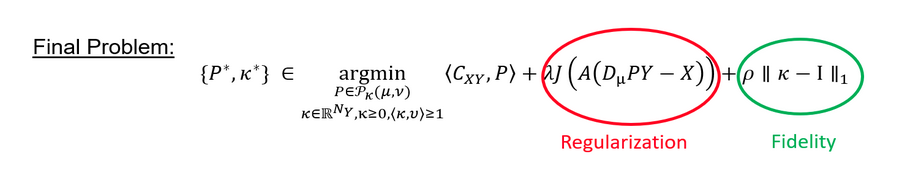

In [ ]:
from IPython.display import Image
Image(filename='constrainted_optimal_transport.png')

So we first started by computing a weighted graph of the clusters’ centroid (Xi) (graph_weights()). 

But when we then tried to solve the optimization problem above, we faced dimension conflicts between our different matrix we have not been able to resolve on due time (taking each of our matrices individually they all seemed to have the appropriate dimensions but once we tried to add them to each other an error was raised every time, we even tried to use different library like gurobipy but similar conflicts were still raised, we would need more time in order to maybe find the matrix we miscomputed to finally be able to resolve the constrained version of the optimal transport problem).



In [ ]:
def graph_weights(X, mu, segments, image):
    """
    Compute the weights between all the clusters of X pairwise to define the neighborhood between them
    inputs: 
        - X: a set of Nx features
        - segments: a 2D array which is an integer mask indicating segment labels
        - image: the input image
        - n_neighbours: number of closest neighbours to keep
    returns:
        - W, a symmetric matrix in which W(i,j) indicates the wheight of the edge that links X(i) to X(j)
    """

    Nx = len(X)
    W = np.zeros((Nx, Nx))

    X_norm = X.copy()
    X_norm[:, 0] = X[:, 0] / (segments.shape[0]-1) #* 255
    X_norm[:, 1] = X[:, 1] / (segments.shape[1]-1) #* 255
    X_norm[:, 2:] = X[:, 2:] / 255

    for idx, _ in np.ndenumerate(W):
        if W[idx[1], idx[0]] > 0:
            W[idx] = W[idx[1], idx[0]] # W symmetric
        if idx[1] != idx[0]: # we do not want the vertice connected with itself
            indexes = np.where(segments==idx[0])
            V = V_Mahalanobis(indexes, image)
            M_dist = mu[idx[0]] * Mahalanobis_distance(X_norm[idx[0]] - X_norm[idx[1]], V)
            #M_dist = 1/ np.linalg.norm(X_norm[idx[0]] - X_norm[idx[1]])
            W[idx] = np.exp(-0.5*M_dist)

    return W


def relaxation_gurobi(X, Y, W, C, mu, nu, l, rho):
    """
    Compute the objective function including regularization constraints of the optimal transport problem
    inputs:
        - X: the first set of features of size Nx of which we want to keep the spatial features
        - Y: the second set of features of size Ny of which we want to keep the color features
        - W: the weighted graph between features X
        - C: the transport cost of X towards Y, a matrix of shape Nx*Ny
        - mu: the weights of features (superpixels) of image u
        - nu: the weights of features (superpixels) of image v
        - l: the regularization parameter of divergence of vector field
        - rho: the fidelity parameter for tight relaxation

    returns:
        - The function we want to relax
    """

    Nx = X.shape[0]
    Ny = Y.shape[0]
    C = (C.T).reshape((Nx*Ny,))
    mu_r = np.diag(mb.repmat(1/mu, 1, Ny)[0])

    Y_mul = np.zeros((3*Nx, Ny*Nx))

    X_mul = np.zeros((3*Nx,))

    for i in range(3):
        X_mul[i*Nx:(i+1)*Nx] = X[:, i+2]

    for i in range(3):
        for j in range(Nx):
            Y_mul[i*Nx+j, j::Nx] = Y[:, i+2]

    # Create a new model
    m = gp.Model("matrix2")

    # Create variables
    P = m.addMVar(Nx*Ny, lb=np.zeros((Nx*Ny,)), ub=np.ones((Nx*Ny,)), name="P")
    k = m.addMVar(Ny, lb=0, name="k")

    D = Y_mul @ mu_r

    """
    In order to add our constraints (regularization & fidelity) to our problem we should have solved one of the following line : 
    
    - m.setObjective(C @ P + l * np.linalg.norm(divergence_vector_field(color_palette_transfer(P, mu, Y) - X[:, 2:], W), ord=1) + rho * np.linalg.norm(k - np.ones((Y.shape[0], ))), GRB.MINIMIZE)

    or 
    
    - m.setObjective(C @ P+ l * D @ P - l * X_mul, GRB.MINIMIZE)

    
    However, we did not succeed after multiple attempts in running the first one using only standard libraries...
    So, as we had seen several implementations online using the library gurobi.py we decided to give it a try using this library but we were not able to solve
    a conflict between the dimensions of our matrix in our sum (taking each of them individually they all had the same dimension but once we tried to add them to each other an error was raised every time)
    """

    # Set objective
    #m.setObjective(C @ P + l * np.linalg.norm(divergence_vector_field(color_palette_transfer(P, mu, Y) - X[:, 2:], W), ord=1) + rho * np.linalg.norm(k - np.ones((Y.shape[0], ))), GRB.MINIMIZE)
    
    m.setObjective(C @ P, GRB.MINIMIZE) #+ l * D @ P - l * X_mul, GRB.MINIMIZE)



    A = np.zeros((Nx, Nx*Ny))
    B = np.zeros((Ny, Nx*Ny))

    for i in range(Nx):
        A[i, i:Nx*Ny:Nx] = 1

    for j in range(Ny):
        B[j, j*Nx:(j+1)*Nx] = 1

    # Add constraints:
    #b = P.T @ np.ones((X.shape[0],))
    #m.addConstr(k >= 0, "c0")
    #m.addConstr(P >= 0, "c1")
    #m.addConstr(P <= 1, "c2")
    m.addConstr(A @ P == mu, "c3")
    m.addConstr(B @ P == nu, "c4")
    #m.addConstr(P @ B <= k * nu, "c4")
    #m.addConstr(np.sum(k * nu) >= 1, "c5")

    # Optimize model
    m.optimize()

    solution = P.X
    
    solution = solution.reshape((Ny, Nx)).T
    print(np.max(solution), np.min(solution))

    return solution #, k


####Color Palette Transfer####

Once we have the weighted graph and that we find the relaxed optimal transport matrix P* (solving the optimization problemm mentioned previously), we define the color transfer function as follows : 

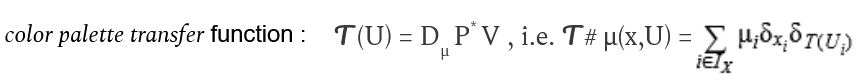

In [ ]:
from IPython.display import Image
Image(filename='color_palette_transfer_function.PNG')

This function enables us to compute the estimated transfered color for each of our clusters. 

In [ ]:
def color_palette_transfer(P, mu, Y):
    """
    A function to transfer the color features of clusters Y to clusters X knowing the transport matrix.
    inputs:
        - P: the transport matrix of X towards Y
        - mu: the weights of clusters X
        - Y: the clusters of image Y

    returns:
        - the color features after transfer 
    """
   
    T_U = np.diag(1/mu)@P@Y[:, 2:] # select only color features of Y

    return T_U


*The next part is not mandatory to achieve color transfer. But we felt it would had some visual understanding of what we are really doing.*

In the next cell code, we basically apply color transfer at the superpixel scale, using our *color palette tranfer* function we just defined.

In [ ]:
def superpixels_transfer(P, mu, Y, segments):
    """
    Attributes new mean color values to superpixels
    inputs:
        - P: the transport matrix of X towards Y
        - mu: the weights of clusters X
        - Y: the clusters of image Y
        - segments: a 2D array which is an integer mask indicating segment labels

    returns:
        - the new superpixel reconstruction
    """

    superpixels = np.zeros((segments.shape[0], segments.shape[1], 3), dtype=int)
    T_U = optimal_transport.color_palette_transfer(P, mu, Y)

    for c in np.unique(segments):
        indexes = np.where(segments==c)
        superpixels[indexes] = np.round(T_U[c]).astype(int)
    
    return superpixels


Results of unconstrained color transfer at the superpixel scale :

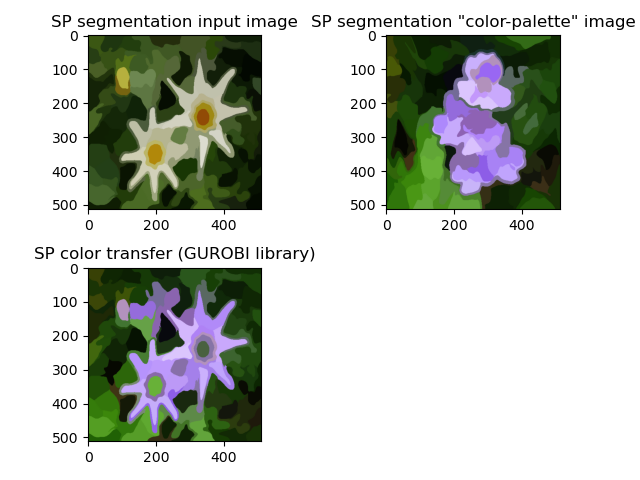

In [ ]:
from IPython.display import Image
Image(filename='Results/gurobitransferSP.png') 

### Image synthesis and post processing

Once we finally have our *color palette transfer* function, we are able to build our color transfered image in the dimensional space of the original image. 

To do so, for each pixel of the source image, once we have the weighted graph and the *color palette transfer* function, the idea is to use the likelihood of all clusters {Xi}i through the weights {wi}i in order to compute a linear combination of the estimated transferred colors T(Ui) at each pixel of the image. 

Doing so we are able to account for the geometry of the original image while applying to it the color distribution of the "color palette" one.

Then, we perform a bit of post-processing applying a filter to the final image in order to recover the sharp details lost in the previous processes. 

In [ ]:
def image_synthesis(X, Y, P, mu, segments, image_u):
    """
    Synthetizing the new image from the spacial features of image u and using the color palette computed after optimal transfer
    inputs:
        - X: a set of Nx features
        - Y: a set of Ny features
        - P: the transport matrix of X towards Y
        - mu: the weight of cluster X
        - segments: a 2D array which is an integer mask indicating segment labels
        - image_u: the input image
    
    returns:
        - The new image containing the spacial features of image u and the color palette of image v
    """

    T_U = optimal_transport.color_palette_transfer(P, mu, Y) #/ 255
    X[:, 0] = X[:, 0] / image_u.shape[0]*255
    X[:, 1] = X[:, 1] / image_u.shape[1]*255

    image_w = np.zeros((image_u.shape[0] * image_u.shape[1], 3))
    Nx = len(X)

    pixels = np.zeros((image_u.shape[0]*image_u.shape[1], 5))

    i = 0
    for idx, _ in np.ndenumerate(segments):
        pixel = np.array([idx[0]/(segments.shape[0]-1)*255, idx[1]/(segments.shape[1]-1)*255, image_u[idx][0], image_u[idx][1], image_u[idx][2]])
        pixels[i] = pixel
        i += 1
    
    W = np.zeros((image_u.shape[0] * image_u.shape[1],))
    for i in range(Nx):
        indexes = np.where(segments==i)
        V = graph.V_Mahalanobis(indexes, image_u)
        L = (pixels - X[i]) / 255 # likelihood 
        wi = np.exp(-np.sum((L@V)*L, axis=1))
        image_w = image_w + np.outer(wi, T_U[i])
        W += wi

    image_w[:, 0] = np.divide(image_w[:, 0], W)
    image_w[:, 1] = np.divide(image_w[:, 1], W)
    image_w[:, 2] = np.divide(image_w[:, 2], W)
    image_w = image_w.reshape((image_u.shape[0], image_u.shape[1], 3))
    image_w = np.round(image_w).astype(int)
    
    return image_w
    
def filtered_image(image_u, image_w, n_iter, r, eps):
    """
    Apply the filter to the synthetized image to restore the sharp details lost during the optimal transport process
    inputs:
        - image_u: the original image
        - image_w: the synthetized image after optimal transport
        - n_iter: the number of iterations to process the filtering on
        - r: the radius of local window of the NLMR filter
        - eps: the regularizaton parameter of the NLMR filter

    returns: 
        - the filtered synthetized image
    """
    image_u = image_u / 255
    w_temp = image_w / 255 - image_u
    for i in range(n_iter):
        w_filtered = filter(image_u, w_temp, r, eps)
        w_temp = w_filtered

    w_filtered_final = np.round((image_u + w_temp)*255).astype(int)

    indexes_min = np.where(w_filtered_final < 0)
    indexes_max = np.where(w_filtered_final > 255)

    while len(indexes_min[0]) > 0:
        w_filtered_final[indexes_min] = 0 # in case of NaN
        for id in range(len(indexes_min[0])):
            l_bound_ax0 = indexes_min[0][id] - 1
            l_bound_ax1 = indexes_min[1][id] - 1
            u_bound_ax0 = indexes_min[0][id] + 2
            u_bound_ax1 = indexes_min[1][id] + 2
            if l_bound_ax0  < 0:
                l_bound_ax0 = 0
            if l_bound_ax1 < 0:
                l_bound_ax1 = 0
            if u_bound_ax0 > image_u.shape[0]:
                u_bound_ax0 = - 1
            if u_bound_ax1 >  image_u.shape[1]:
                u_bound_ax1 = - 1
            interpolation_raw = w_filtered_final[l_bound_ax0:u_bound_ax0, l_bound_ax1:u_bound_ax1, indexes_min[2][id]].copy()
            positive_interpolation_idx = np.where(interpolation_raw > 0)
            interpolation = interpolation_raw[positive_interpolation_idx]
            if len(interpolation) >= 1:
                w_filtered_final[indexes_min[0][id], indexes_min[1][id], indexes_min[2][id]] = np.median(interpolation)
        indexes_min = np.where(w_filtered_final < 0)
    
    while len(indexes_max[0]) > 0:
        w_filtered_final[indexes_max] = 0 # in case of NaN
        for id in range(len(indexes_max[0])):  
            l_bound_ax0 = indexes_max[0][id] - 1
            l_bound_ax1 = indexes_max[1][id] - 1
            u_bound_ax0 = indexes_max[0][id] + 2
            u_bound_ax1 = indexes_max[1][id] + 2
            if l_bound_ax0 == -1:
                l_bound_ax0 = 0
            if l_bound_ax1 == -1:
                l_bound_ax1 = 0
            if u_bound_ax0 == image_u.shape[0] + 1:
                u_bound_ax0 = - 1
            if u_bound_ax1 == image_u.shape[1] + 1:
                u_bound_ax1 = - 1
            interpolation_raw = w_filtered_final[l_bound_ax0:u_bound_ax0, l_bound_ax1:u_bound_ax1, indexes_max[2][id]].copy()
            positive_interpolation_idx = np.where(interpolation_raw > 0)
            interpolation = interpolation_raw[positive_interpolation_idx]
            if len(interpolation) >= 1:
                w_filtered_final[indexes_max[0][id], indexes_max[1][id], indexes_max[2][id]] = np.median(interpolation)
        indexes_max = np.where(w_filtered_final > 255)

    return w_filtered_final

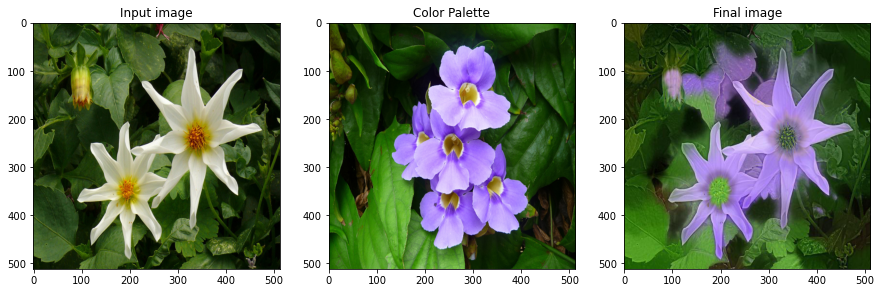

In [ ]:
input = plt.imread("Data/flower_1.jpg")
c_palette = plt.imread("Data/flower_2.jpg")
final = plt.imread("Results/Images/FinalImage.jpg")

plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.title("Input image")
plt.imshow(input)
plt.subplot(1, 3, 2)
plt.title("Color Palette")
plt.imshow(c_palette)
plt.subplot(1, 3, 3)
plt.title("Final image")
plt.imshow(final)
plt.show()

The final is the result of color transfer based on an optimal transport matrix P computed by solving only the **unconstrained** optimization problem, which as we would expect result in some spatial irregularities (some leaves having the same color as the petals) ...

## Metrics

The main issue of this algorithm is to find a way to evaluate our results.  
This aspect was not tackled in the paper but we thought that being able to assess objectively the results was still an important part of a project. 

We looked at two/three different metrics :  
1. **PSNR (Peak Signal to Noise Ratio)**
2. **SSIM (Structural Similarity index measure)**
3. **Bhattacharyya distance**  

To test each of those metrics we used the input image and the final image of the following cell.


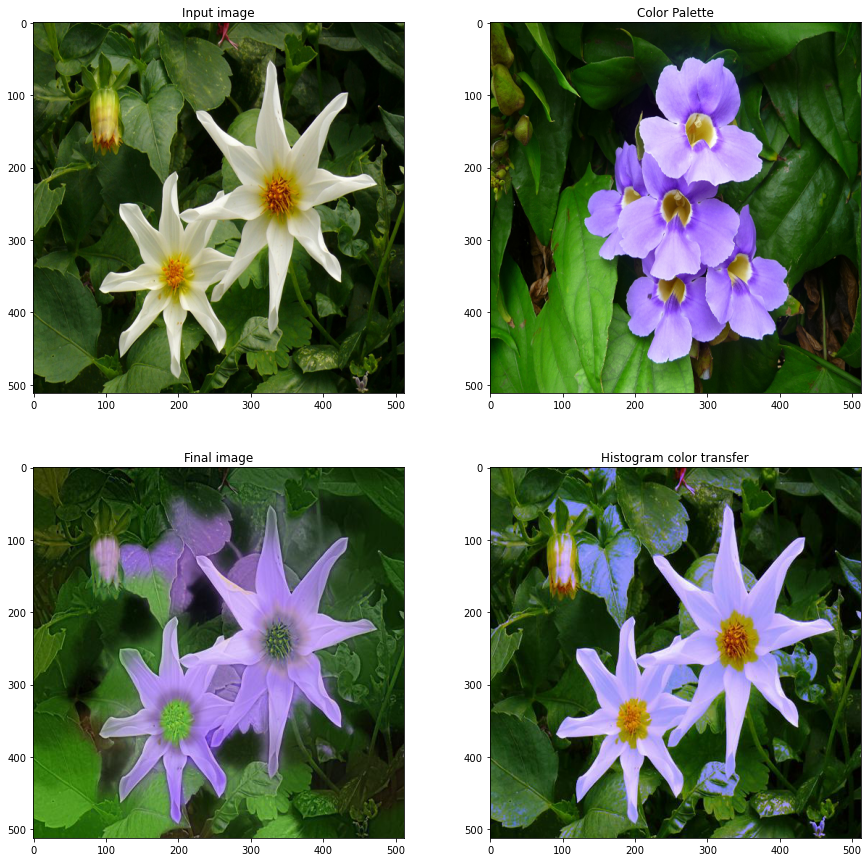

In [ ]:
input = plt.imread("Data/flower_1.jpg")
c_palette = plt.imread("Data/flower_2.jpg")
final = plt.imread("Results/Images/FinalImage.jpg")
histo = plt.imread("Results/Images/histo.jpg")

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.title("Input image")
plt.imshow(input)
plt.subplot(2, 2, 2)
plt.title("Color Palette")
plt.imshow(c_palette)
plt.subplot(2, 2, 3)
plt.title("Final image")
plt.imshow(final)
plt.subplot(2, 2, 4)
plt.title("Histogram color transfer")
plt.imshow(histo)
plt.show()

We also tried implementing a basic approach that comes first to mind when we think of color transfer, which would be matching the color distribution of the image 2 to the image 1. As expected the results were not really satisfying, as you can see the 4th image displayed above "Histogram color transfer" is the result of such processing and it does not seem like "color transfer" has really been applied, it feels more like a purple filter has been applied to the whole original image.

**PSNR (Peak Signal to Noise Ratio)**: PSNR is a common metric used to quantify reconstruction quality for images. 
The PSNR between an image $x$ and $y$ is defined as follows : $PSNR(x,y)=10*log_{10}(\frac{(2^d-1)}{MSE(x,y)})$ with d the number of bits and MSE the mean squared error between the two images.  

The higher the PSNR, the more similar the images.

In [ ]:
from skimage.metrics import mean_squared_error
def PSNR(u,v):
    mse = mean_squared_error(u,v)
    d = 2**8-1 #Images are encoded on 8 bits
    psnr = 10*np.log10((d**2)/mse)
    return psnr
psnr = PSNR(input,final)
psnrh = PSNR(input,histo)
print(f"The PSNR between the input and final image is {round(psnr,4)}")
print(f"The PSNR between the input and histogram transfert image is {round(psnrh,4)}")

The PSNR between the input and final image is 15.9983
The PSNR between the input and histogram transfert image is 18.6214


**SSIM (Structural Similarity index measure)**: This is a method for predicting the perceived quality of digital images.  

SSIM is a perception-based model that considers image degradation as perceived change in structural information, while also incorporating important perceptual phenomena, including both luminance masking and contrast masking terms.  

It is defined as follows for two images $x$ and $y$ : $SSIM(x,y) = \frac{(2\mu_x\mu_y + c_1)(2\sigma_x\sigma_y + c_2)(cov_{xy} + c_3)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)(\sigma_x \sigma_y + c_3)}$ with $c_1$,$c_2$,$c_3$ some empirical constants.
 
The main advantage over PSNR which is a pixel-to-pixel difference, the SSIM metric measures the structural similarity between the two images.  

The closer the SSIM is to 1, the greater the similarity between images.

In [ ]:
from skimage.metrics import structural_similarity as ssim
def SSIM(u,v):
    max,min = np.max([np.amax(u),np.amax(v)]), np.min([np.amin(u),np.amin(v)])

    ssim_ = ssim(u, v, data_range=max - min,multichannel=True)
    return ssim_

ssim_ = SSIM(input,final)
ssimh = SSIM(input,histo)
print(f"The SSIM between the input and final image is {round(ssim_,4)}")
print(f"The SSIM between the input and histogram transfert image is {round(ssimh,4)}")

The SSIM between the input and final image is 0.6594
The SSIM between the input and histogram transfert image is 0.8205


In general, metrics are better for the histogram transfer than the technique of the article.  
We can have different answers to this paradox:  
- As we mentionned before, there is no real metrics to measure the accuracy of our algorithm and maybe the ones we use are wrong.
- It might be explain by the uncertainty of the realisation of the algorithm as well as the lack of complexity of the images used.
- Simply, the histogram technique is just better that our complex superpixel segmentation combined with optimal transport (We hope it is not this outcome).

**Bhattacharyya distance**: In statistics, the Bhattacharyya distance measures the similarity of two probability distributions. It is closely related to the Bhattacharyya coefficient which is a measure of the amount of overlap between two statistical samples or populations.  
For probability distributions $p$ and $q$ over the same domain $X$, the Bhattacharyya distance is defined as 
:  
$D_B(p,q) = -\ln \left( BC(p,q) \right)$ where $BC(p,q) = \sum_{x\in X} \sqrt{p(x) q(x)}$
is the **Bhattacharyya coefficient** for discrete probability distributions.

We did not had time to implement the bhattacharyya distance but we thought it would be a good starting point to have a metric able to assess the similarity of the color distribution between the final image and the color palette one.

*To continue* 

Since, the problem is to find a new image w whose geometry is as close as possible to the source image u and whose color distribution is close to the one of the exemplar image v. We thought that constructing a new metric by combination of a metric accounting for the geometry/structure (such as PSNR or SSIM) and another one accounting for the color aspect (such as bhattacharyya maybe).